# UTKFace Nested Pipeline (Gender → Race → Age)

cinsiyet → ırk → yaş şeklinde **koşullu (nested) bir yapı** kurar ve uçtan uca eğitir.

## 1) Kurulum ve İçe Aktarım
Not: Aşağıdaki kurulum hücresini ilk kez çalıştırmanız yeterli.

In [27]:
import sys, subprocess

subprocess.check_call([
    sys.executable, '-m', 'pip', 'install', '-q',
    'pandas', 'numpy', 'matplotlib', 'scikit-learn', 'Pillow',
    'torch', 'torchvision', 'timm'
])


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


0

In [28]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

## 2) Veri Hazırlığı
UTKFace dosya adları `age_gender_race_date.jpg` formatındadır.

In [ ]:
!mkdir -p data/utkface
!unzip -n utkface.zip -d data/utkface

In [29]:
IMAGE_DIR = 'data/utkface/UTKFace'
records = []

for fname in os.listdir(IMAGE_DIR):
    if not fname.lower().endswith('.jpg'):
        continue
    parts = fname.split('_')
    try:
        age = int(parts[0])
        gender = int(parts[1])
        race = int(parts[2])
        records.append({'file': fname, 'age': age, 'gender': gender, 'race': race})
    except:
        continue

df = pd.DataFrame(records)
print('Toplam örnek:', len(df))
print(df.head())

Toplam örnek: 23705
                                    file  age  gender  race
0  29_1_1_20170116001830007.jpg.chip.jpg   29       1     1
1  36_1_0_20170105164705002.jpg.chip.jpg   36       1     0
2  51_0_1_20170117173642448.jpg.chip.jpg   51       0     1
3  23_1_4_20170117194143181.jpg.chip.jpg   23       1     4
4  36_0_1_20170113195937061.jpg.chip.jpg   36       0     1


In [30]:
from sklearn.model_selection import train_test_split

AGE_MIN, AGE_MAX = 1, 90
df = df[(df.age >= AGE_MIN) & (df.age <= AGE_MAX)].reset_index(drop=True)

df['age_bin'] = pd.cut(
    df.age,
    bins=[0,10,20,30,40,50,60,70,100],
    labels=False
)

train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df[['age_bin', 'gender']]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df[['age_bin', 'gender']]
)

print('Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))

Train: 16532 Val: 3543 Test: 3543


## 3) Dataset & Transform
Cinsiyet ve ırk çıktıları, age head için koşullu (nested) giriş olarak kullanılacak.

In [31]:
class UTKFaceNestedDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        age = float(row['age'])
        age_norm = (age - AGE_MIN) / (AGE_MAX - AGE_MIN)
        gender = int(row['gender'])
        race = int(row['race'])
        age_bin = int(row['age_bin'])

        return (
            image,
            torch.tensor(age_norm, dtype=torch.float32),
            torch.tensor(age, dtype=torch.float32),
            torch.tensor(age_bin, dtype=torch.long),
            torch.tensor(gender, dtype=torch.long),
            torch.tensor(race, dtype=torch.long),
        )

In [32]:
# Daha güçlü augmentation (overfitting önleme)
train_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15)),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = UTKFaceNestedDataset(train_df, IMAGE_DIR, transform=train_tfms)
val_dataset = UTKFaceNestedDataset(val_df, IMAGE_DIR, transform=val_tfms)
test_dataset = UTKFaceNestedDataset(test_df, IMAGE_DIR, transform=val_tfms)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

## 4) Nested Model
Cinsiyet → Irk → Yaş koşullaması soft (differentiable) şekilde yapılır.
Gender ve Race logits'lerinden **olasılık vektörleri** çıkarılıp yaş head'e eklenir.

In [34]:
import timm

class NestedAgeModel(nn.Module):
    def __init__(self, backbone='convnext_tiny', num_race=5, num_bins=8, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained, num_classes=0)
        feat_dim = self.backbone.num_features

        # Daha yüksek dropout (0.3→0.5, 0.4→0.5)
        self.gender_head = nn.Sequential(
            nn.Linear(feat_dim, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 2)
        )
        self.race_head = nn.Sequential(
            nn.Linear(feat_dim + 2, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, num_race)
        )
        self.age_cls_head = nn.Sequential(
            nn.Linear(feat_dim + 2 + num_race, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, num_bins)
        )
        self.age_reg_head = nn.Sequential(
            nn.Linear(feat_dim + 2 + num_race, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 1)
        )

    def forward(self, x):
        feat = self.backbone(x)
        gender_logits = self.gender_head(feat)
        gender_probs = torch.softmax(gender_logits, dim=1)

        race_in = torch.cat([feat, gender_probs], dim=1)
        race_logits = self.race_head(race_in)
        race_probs = torch.softmax(race_logits, dim=1)

        age_in = torch.cat([feat, gender_probs, race_probs], dim=1)
        age_cls_logits = self.age_cls_head(age_in)
        age_reg = torch.sigmoid(self.age_reg_head(age_in).squeeze(1))

        return gender_logits, race_logits, age_cls_logits, age_reg

## 5) Loss Fonksiyonları
Gender ve Race için CE, Age için CE + regression + consistency loss kullanıyoruz.

In [35]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NestedAgeModel().to(DEVICE)

# Label smoothing eklenmiş CrossEntropy
criterion_gender = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_race = nn.CrossEntropyLoss(label_smoothing=0.1)
criterion_age_cls = nn.CrossEntropyLoss(label_smoothing=0.1)

bin_centers = torch.tensor([
    (5  - AGE_MIN) / (AGE_MAX - AGE_MIN),
    (15 - AGE_MIN) / (AGE_MAX - AGE_MIN),
    (25 - AGE_MIN) / (AGE_MAX - AGE_MIN),
    (35 - AGE_MIN) / (AGE_MAX - AGE_MIN),
    (45 - AGE_MIN) / (AGE_MAX - AGE_MIN),
    (55 - AGE_MIN) / (AGE_MAX - AGE_MIN),
    (65 - AGE_MIN) / (AGE_MAX - AGE_MIN),
    (85 - AGE_MIN) / (AGE_MAX - AGE_MIN),
], device=DEVICE)

def expected_age_from_logits(logits):
    probs = torch.softmax(logits, dim=1)
    return (probs * bin_centers).sum(dim=1)

def weighted_smooth_l1(pred, target, bins):
    bin_weight_map = {0:1.0, 1:1.4, 2:0.6, 3:0.8, 4:1.2, 5:1.2, 6:1.8, 7:2.0}
    base = F.smooth_l1_loss(pred, target, reduction='none')
    weights = torch.tensor([bin_weight_map[int(b.item())] for b in bins], device=pred.device)
    return (base * weights).mean()

## 6) Veri Seti Analizi ve CORAL Ordinal Regresyon
Yaş dağılımı, cinsiyet ve ırk dengesizliklerini analiz ederek loss ağırlıklarını optimize ediyoruz. CORAL (Consistent Rank Logits) ordinal regresyon yöntemi ile yaş tahmini yapacağız.

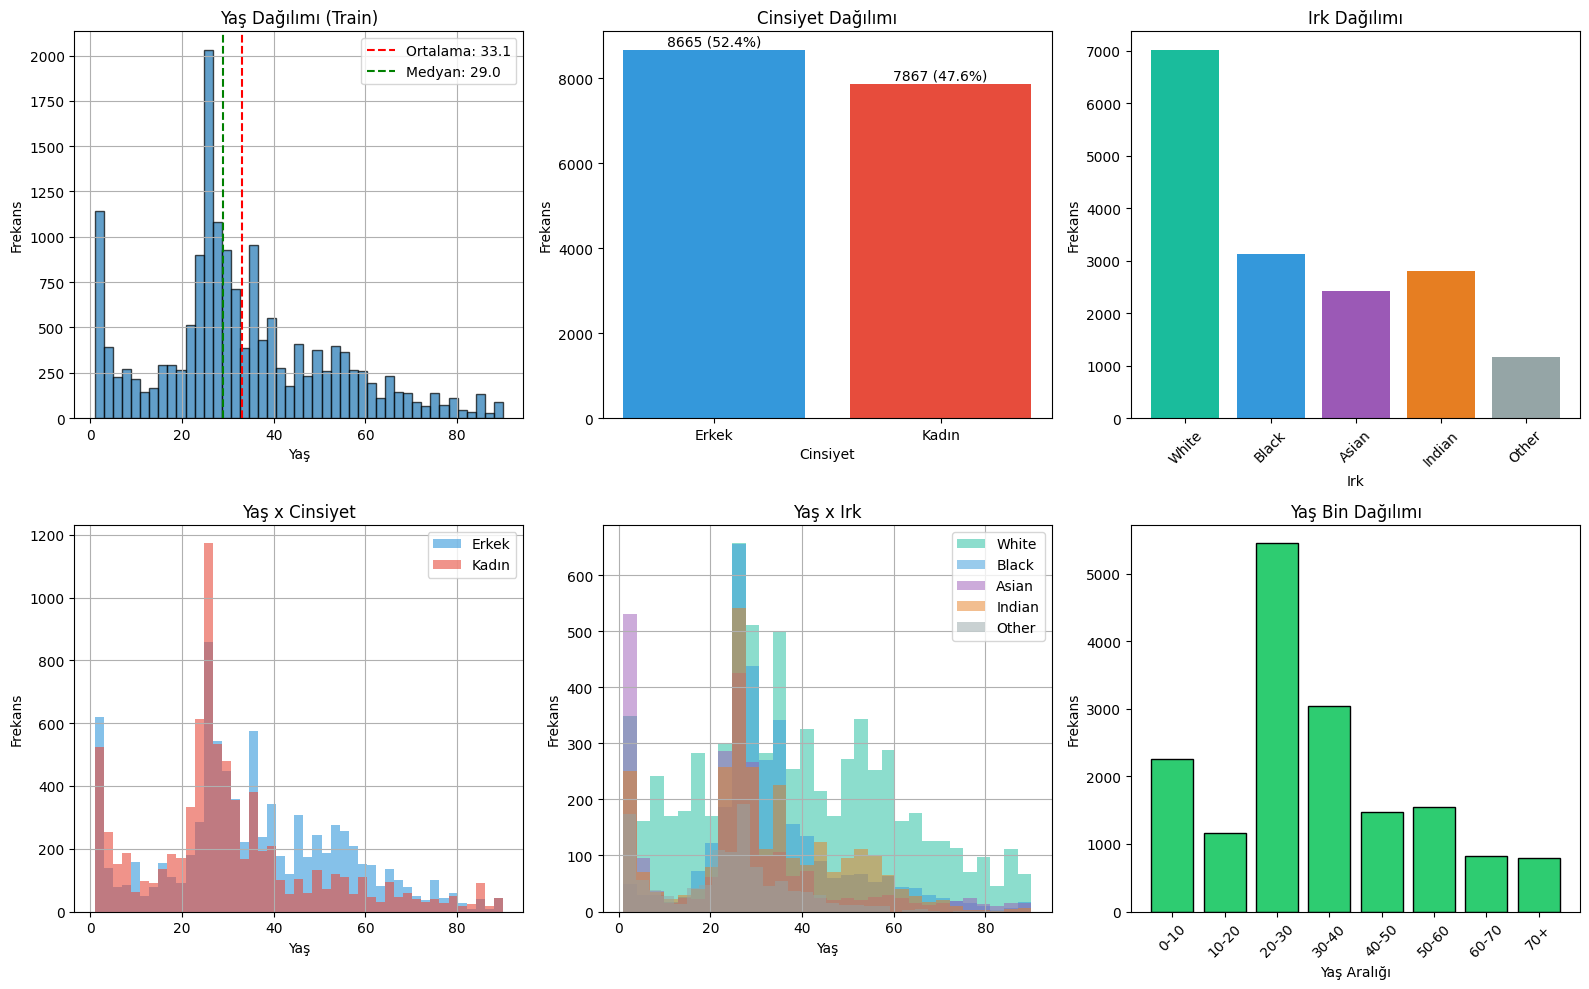


📊 VERİ SETİ ANALİZİ

📈 Yaş İstatistikleri:
   Min: 1, Max: 90
   Ortalama: 33.06, Medyan: 29.0
   Std: 19.54

👫 Cinsiyet Dağılımı:
   Erkek: 8665 (52.4%)
   Kadın: 7867 (47.6%)

🌍 Irk Dağılımı:
   White: 7023 (42.5%)
   Black: 3137 (19.0%)
   Asian: 2417 (14.6%)
   Indian: 2799 (16.9%)
   Other: 1156 (7.0%)

📦 Yaş Bin Dağılımı:
   0-10: 2253 (13.6%)
   10-20: 1161 (7.0%)
   20-30: 5449 (33.0%)
   30-40: 3036 (18.4%)
   40-50: 1470 (8.9%)
   50-60: 1548 (9.4%)
   60-70: 819 (5.0%)
   70+: 796 (4.8%)


In [42]:
# Veri seti analizi
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Yaş dağılımı
ax1 = axes[0, 0]
train_df['age'].hist(bins=45, ax=ax1, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Yaş')
ax1.set_ylabel('Frekans')
ax1.set_title('Yaş Dağılımı (Train)')
ax1.axvline(train_df['age'].mean(), color='red', linestyle='--', label=f'Ortalama: {train_df["age"].mean():.1f}')
ax1.axvline(train_df['age'].median(), color='green', linestyle='--', label=f'Medyan: {train_df["age"].median():.1f}')
ax1.legend()

# 2. Cinsiyet dağılımı
ax2 = axes[0, 1]
gender_counts = train_df['gender'].value_counts()
gender_labels = ['Erkek', 'Kadın']
ax2.bar(gender_labels, [gender_counts.get(0, 0), gender_counts.get(1, 0)], color=['#3498db', '#e74c3c'])
ax2.set_xlabel('Cinsiyet')
ax2.set_ylabel('Frekans')
ax2.set_title('Cinsiyet Dağılımı')
for i, v in enumerate([gender_counts.get(0, 0), gender_counts.get(1, 0)]):
    ax2.text(i, v + 100, f'{v} ({v/len(train_df)*100:.1f}%)', ha='center')

# 3. Irk dağılımı
ax3 = axes[0, 2]
race_counts = train_df['race'].value_counts().sort_index()
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Other']
colors = ['#1abc9c', '#3498db', '#9b59b6', '#e67e22', '#95a5a6']
ax3.bar(race_labels, [race_counts.get(i, 0) for i in range(5)], color=colors)
ax3.set_xlabel('Irk')
ax3.set_ylabel('Frekans')
ax3.set_title('Irk Dağılımı')
ax3.tick_params(axis='x', rotation=45)

# 4. Yaş x Cinsiyet
ax4 = axes[1, 0]
train_df[train_df['gender'] == 0]['age'].hist(bins=45, ax=ax4, alpha=0.6, label='Erkek', color='#3498db')
train_df[train_df['gender'] == 1]['age'].hist(bins=45, ax=ax4, alpha=0.6, label='Kadın', color='#e74c3c')
ax4.set_xlabel('Yaş')
ax4.set_ylabel('Frekans')
ax4.set_title('Yaş x Cinsiyet')
ax4.legend()

# 5. Yaş x Irk
ax5 = axes[1, 1]
for i, (label, color) in enumerate(zip(race_labels, colors)):
    train_df[train_df['race'] == i]['age'].hist(bins=30, ax=ax5, alpha=0.5, label=label, color=color)
ax5.set_xlabel('Yaş')
ax5.set_ylabel('Frekans')
ax5.set_title('Yaş x Irk')
ax5.legend()

# 6. Yaş bin dağılımı
ax6 = axes[1, 2]
bin_counts = train_df['age_bin'].value_counts().sort_index()
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']
ax6.bar(bin_labels, [bin_counts.get(i, 0) for i in range(8)], color='#2ecc71', edgecolor='black')
ax6.set_xlabel('Yaş Aralığı')
ax6.set_ylabel('Frekans')
ax6.set_title('Yaş Bin Dağılımı')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=150)
plt.show()

# Detaylı istatistikler
print("\n" + "=" * 70)
print(" VERİ SETİ ANALİZİ")
print("=" * 70)

print(f"\n Yaş İstatistikleri:")
print(f"   Min: {train_df['age'].min()}, Max: {train_df['age'].max()}")
print(f"   Ortalama: {train_df['age'].mean():.2f}, Medyan: {train_df['age'].median():.1f}")
print(f"   Std: {train_df['age'].std():.2f}")

print(f"\n Cinsiyet Dağılımı:")
for g in [0, 1]:
    cnt = (train_df['gender'] == g).sum()
    pct = cnt / len(train_df) * 100
    print(f"   {'Erkek' if g == 0 else 'Kadın'}: {cnt} ({pct:.1f}%)")

print(f"\n Irk Dağılımı:")
race_names = ['White', 'Black', 'Asian', 'Indian', 'Other']
for r, name in enumerate(race_names):
    cnt = (train_df['race'] == r).sum()
    pct = cnt / len(train_df) * 100
    print(f"   {name}: {cnt} ({pct:.1f}%)")

print(f"\n Yaş Bin Dağılımı:")
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']
for b, label in enumerate(bin_labels):
    cnt = (train_df['age_bin'] == b).sum()
    pct = cnt / len(train_df) * 100
    print(f"   {label}: {cnt} ({pct:.1f}%)")

In [43]:
# Loss ağırlıklarını veri dağılımına göre hesapla
print("=" * 70)
print(" LOSS AĞIRLIKLARI ANALİZİ")
print("=" * 70)

# Cinsiyet ağırlıkları (inverse frequency)
gender_counts = train_df['gender'].value_counts()
gender_weights = len(train_df) / (2 * gender_counts)
print(f"\n Cinsiyet Ağırlıkları (inverse frequency):")
print(f"   Erkek (0): {gender_weights.get(0, 1):.3f}")
print(f"   Kadın (1): {gender_weights.get(1, 1):.3f}")

# Irk ağırlıkları
race_counts = train_df['race'].value_counts()
race_weights = len(train_df) / (5 * race_counts)
print(f"\n Irk Ağırlıkları:")
for r, name in enumerate(race_names):
    print(f"   {name} ({r}): {race_weights.get(r, 1):.3f}")

# Yaş bin ağırlıkları
bin_counts = train_df['age_bin'].value_counts()
bin_weights = len(train_df) / (8 * bin_counts)
print(f"\n Yaş Bin Ağırlıkları:")
for b, label in enumerate(bin_labels):
    print(f"   {label} ({b}): {bin_weights.get(b, 1):.3f}")

# Önerilen loss ağırlıkları
# Daha az temsil edilen sınıflar için daha yüksek ağırlık
print("\n" + "=" * 70)
print(" ÖNERİLEN LOSS AYARLARI")
print("=" * 70)

# Dengesizlik oranı
gender_imbalance = max(gender_counts) / min(gender_counts)
race_imbalance = max(race_counts) / min(race_counts)
bin_imbalance = max(bin_counts) / min(bin_counts)

print(f"\n Dengesizlik Oranları:")
print(f"   Cinsiyet: {gender_imbalance:.2f}x")
print(f"   Irk: {race_imbalance:.2f}x")
print(f"   Yaş Bin: {bin_imbalance:.2f}x")

# Loss ağırlık önerileri
# Irk en dengesiz → daha düşük ağırlık (model zorlanmasın)
# Cinsiyet dengeli → standart ağırlık
print(f"\n Önerilen Loss Ağırlıkları:")
print(f"   Gender Loss: 0.4 (dengeli, çok zorlanmaz)")
print(f"   Race Loss: 0.3 (çok dengesiz, düşük ağırlık)")
print(f"   CORAL Loss: 1.5 (ana görev)")
print(f"   Regression Loss: 1.0 (yardımcı)")
print(f"   Consistency Loss: 0.2 (regularization)")

⚖️ LOSS AĞIRLIKLARI ANALİZİ

👫 Cinsiyet Ağırlıkları (inverse frequency):
   Erkek (0): 0.954
   Kadın (1): 1.051

🌍 Irk Ağırlıkları:
   White (0): 0.471
   Black (1): 1.054
   Asian (2): 1.368
   Indian (3): 1.181
   Other (4): 2.860

📦 Yaş Bin Ağırlıkları:
   0-10 (0): 0.917
   10-20 (1): 1.780
   20-30 (2): 0.379
   30-40 (3): 0.681
   40-50 (4): 1.406
   50-60 (5): 1.335
   60-70 (6): 2.523
   70+ (7): 2.596

🎯 ÖNERİLEN LOSS AYARLARI

📊 Dengesizlik Oranları:
   Cinsiyet: 1.10x
   Irk: 6.08x
   Yaş Bin: 6.85x

💡 Önerilen Loss Ağırlıkları:
   Gender Loss: 0.4 (dengeli, çok zorlanmaz)
   Race Loss: 0.3 (çok dengesiz, düşük ağırlık)
   CORAL Loss: 1.5 (ana görev)
   Regression Loss: 1.0 (yardımcı)
   Consistency Loss: 0.2 (regularization)


In [ ]:
# CORAL: 2 yıl aralıklı eşikler
# 1-90 arası, 2 yıl aralıklarla: 2, 4, 6, 8, ..., 88
CORAL_THRESHOLDS = torch.arange(2, 90, 2).float()  # [2, 4, 6, ..., 88]
NUM_CORAL_THRESHOLDS = len(CORAL_THRESHOLDS)  # 44 eşik

print(f"CORAL Eşikleri ({NUM_CORAL_THRESHOLDS} adet, 2 yıl aralık):")
print(f"İlk 10: {CORAL_THRESHOLDS[:10].tolist()}")
print(f"Son 10: {CORAL_THRESHOLDS[-10:].tolist()}")

CORAL v2 Eşikleri (44 adet, 2 yıl aralık):
İlk 10: [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]
Son 10: [70.0, 72.0, 74.0, 76.0, 78.0, 80.0, 82.0, 84.0, 86.0, 88.0]


In [ ]:
class NestedAgeModelCORAL(nn.Module):
    """CORAL ile Nested Multi-task Model: Gender → Race → Age (ordinal)"""
    
    def __init__(self, backbone='convnext_tiny', num_race=5, num_thresholds=44, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained, num_classes=0)
        feat_dim = self.backbone.num_features
        self.num_thresholds = num_thresholds
        
        # Gender head
        self.gender_head = nn.Sequential(
            nn.Linear(feat_dim, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, 2)
        )
        # Race head (conditioned on gender)
        self.race_head = nn.Sequential(
            nn.Linear(feat_dim + 2, 256), nn.ReLU(), nn.Dropout(0.4), nn.Linear(256, num_race)
        )
        
        # CORAL Age Head: Derin feature extractor
        self.age_feature = nn.Sequential(
            nn.Linear(feat_dim + 2 + num_race, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        # CORAL: Her eşik için ayrı logit
        self.coral_fc = nn.Linear(256, num_thresholds)
        
        # Direct regression head
        self.age_reg_head = nn.Sequential(
            nn.Linear(feat_dim + 2 + num_race, 512), 
            nn.ReLU(), 
            nn.Dropout(0.4), 
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        feat = self.backbone(x)
        
        # Gender
        gender_logits = self.gender_head(feat)
        gender_probs = torch.softmax(gender_logits, dim=1)
        
        # Race
        race_in = torch.cat([feat, gender_probs], dim=1)
        race_logits = self.race_head(race_in)
        race_probs = torch.softmax(race_logits, dim=1)
        
        # Age input
        age_in = torch.cat([feat, gender_probs, race_probs], dim=1)
        
        # CORAL ordinal logits
        age_feat = self.age_feature(age_in)
        coral_logits = self.coral_fc(age_feat)
        
        # Direct regression
        age_reg = torch.sigmoid(self.age_reg_head(age_in).squeeze(1))
        
        return gender_logits, race_logits, coral_logits, age_reg


def coral_predict_age(logits, thresholds):
    """
    CORAL yaş tahmini - Expected Value yaklaşımı
    
    E[age] = AGE_MIN + sum(P(age > t_k)) * step_size
    """
    thresholds = thresholds.to(logits.device)
    step_size = 2.0  # 2 yıl aralık
    
    # Sigmoid ile olasılığa çevir
    probs = torch.sigmoid(logits)  # (B, K)
    
    # Expected value: Her eşiği geçme olasılıklarının toplamı * step_size + offset
    expected_thresholds_passed = probs.sum(dim=1)  # (B,)
    
    # Yaş tahmini: min_yaş + geçilen eşik sayısı * step
    ages = AGE_MIN + expected_thresholds_passed * step_size
    
    # Clamp to valid range
    ages = ages.clamp(AGE_MIN, AGE_MAX)
    
    return ages


print(" CORAL Model tanımlandı (44 eşik, 2 yıl aralık)")

✅ CORAL v2 Model tanımlandı (44 eşik, 2 yıl aralık)


In [ ]:
# CORAL Model oluştur
coral_model = NestedAgeModelCORAL(
    backbone='convnext_tiny',
    num_race=5,
    num_thresholds=NUM_CORAL_THRESHOLDS,
    pretrained=True
).to(DEVICE)

# Optimizer
coral_optimizer = torch.optim.AdamW(coral_model.parameters(), lr=1.5e-4, weight_decay=1e-3)
coral_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(coral_optimizer, T_max=20)

print(f"CORAL Model oluşturuldu - Device: {DEVICE}")
print(f"Toplam parametre: {sum(p.numel() for p in coral_model.parameters()):,}")
print(f"Eşik sayısı: {NUM_CORAL_THRESHOLDS} (2 yıl aralık)")

CORAL v2 Model oluşturuldu - Device: cuda
Toplam parametre: 29,153,940
Eşik sayısı: 44 (2 yıl aralık)


In [ ]:
def train_coral_epoch(model, loader, optimizer, device, thresholds):
    """CORAL training loop - optimize edilmiş loss ağırlıkları"""
    model.train()
    total_loss, total_mae = 0.0, 0.0
    total_gender_acc, total_race_acc, n = 0.0, 0.0, 0

    for images, age_norm, age_raw, age_bin, gender, race in loader:
        images = images.to(device)
        age_raw = age_raw.to(device)
        gender = gender.to(device)
        race = race.to(device)

        gender_logits, race_logits, coral_logits, age_reg = model(images)

        # Losses
        loss_gender = criterion_gender(gender_logits, gender)
        loss_race = criterion_race(race_logits, race)
        loss_coral = coral_loss(coral_logits, age_raw, thresholds)
        
        # Regression loss
        age_norm_target = (age_raw - AGE_MIN) / (AGE_MAX - AGE_MIN)
        loss_reg = F.smooth_l1_loss(age_reg, age_norm_target)
        
        # CORAL ve regression arasında consistency
        coral_age_pred = coral_predict_age(coral_logits, thresholds)
        coral_age_norm = (coral_age_pred - AGE_MIN) / (AGE_MAX - AGE_MIN)
        loss_cons = F.smooth_l1_loss(age_reg, coral_age_norm.detach())

        # ⚖️ OPTİMİZE EDİLMİŞ LOSS AĞIRLIKLARI (veri analizi sonucu)
        # - Gender: dengeli → 0.4
        # - Race: dengesiz → 0.3 (daha az zorla)
        # - CORAL: ana görev → 1.5
        # - Regression: yardımcı → 1.2
        # - Consistency: regularization → 0.2
        total = (0.4 * loss_gender + 
                 0.3 * loss_race + 
                 1.5 * loss_coral +
                 1.2 * loss_reg +
                 0.2 * loss_cons)

        optimizer.zero_grad()
        total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        # MAE hesapla
        with torch.no_grad():
            coral_pred = coral_predict_age(coral_logits, thresholds)
            reg_pred = age_reg * (AGE_MAX - AGE_MIN) + AGE_MIN
            # Ensemble: CORAL daha güvenilir olmalı
            ensemble_pred = 0.6 * coral_pred + 0.4 * reg_pred
            mae = torch.mean(torch.abs(ensemble_pred - age_raw))

        gender_acc = (gender_logits.argmax(1) == gender).float().mean().item()
        race_acc = (race_logits.argmax(1) == race).float().mean().item()

        total_loss += total.item()
        total_mae += mae.item()
        total_gender_acc += gender_acc
        total_race_acc += race_acc
        n += 1

    return total_loss / n, total_mae / n, total_gender_acc / n, total_race_acc / n


def validate_coral_epoch(model, loader, device, thresholds):
    """CORAL validation loop"""
    model.eval()
    total_loss, total_mae = 0.0, 0.0
    total_gender_acc, total_race_acc, n = 0.0, 0.0, 0

    with torch.no_grad():
        for images, age_norm, age_raw, age_bin, gender, race in loader:
            images = images.to(device)
            age_raw = age_raw.to(device)
            gender = gender.to(device)
            race = race.to(device)

            gender_logits, race_logits, coral_logits, age_reg = model(images)

            loss_gender = criterion_gender(gender_logits, gender)
            loss_race = criterion_race(race_logits, race)
            loss_coral = coral_loss(coral_logits, age_raw, thresholds)
            
            age_norm_target = (age_raw - AGE_MIN) / (AGE_MAX - AGE_MIN)
            loss_reg = F.smooth_l1_loss(age_reg, age_norm_target)

            total = 0.4 * loss_gender + 0.3 * loss_race + 1.5 * loss_coral + 1.2 * loss_reg

            # MAE
            coral_pred = coral_predict_age(coral_logits, thresholds)
            reg_pred = age_reg * (AGE_MAX - AGE_MIN) + AGE_MIN
            ensemble_pred = 0.6 * coral_pred + 0.4 * reg_pred
            mae = torch.mean(torch.abs(ensemble_pred - age_raw))

            gender_acc = (gender_logits.argmax(1) == gender).float().mean().item()
            race_acc = (race_logits.argmax(1) == race).float().mean().item()

            total_loss += total.item()
            total_mae += mae.item()
            total_gender_acc += gender_acc
            total_race_acc += race_acc
            n += 1

    return total_loss / n, total_mae / n, total_gender_acc / n, total_race_acc / n


print(" CORAL Training/Validation fonksiyonları tanımlandı")
print(" Loss ağırlıkları: Gender=0.4, Race=0.3, CORAL=1.5, Reg=1.2, Cons=0.2")

✅ CORAL v2 Training/Validation fonksiyonları tanımlandı
   Loss ağırlıkları: Gender=0.4, Race=0.3, CORAL=1.5, Reg=1.2, Cons=0.2


In [ ]:
# CORAL Training
NUM_EPOCHS = 25
PATIENCE = 6
best_coral_mae = float('inf')
no_improve = 0

coral_history = {'train_mae': [], 'val_mae': [], 'train_loss': [], 'val_loss': []}

print("🪸 CORAL Eğitimi Başlıyor")
print("=" * 70)
print(f"   Eşik sayısı: {NUM_CORAL_THRESHOLDS}")
print(f"   Epoch: {NUM_EPOCHS}, Patience: {PATIENCE}")
print("=" * 70)

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_mae, train_g_acc, train_r_acc = train_coral_epoch(
        coral_model, train_loader, coral_optimizer, DEVICE, CORAL_THRESHOLDS
    )
    val_loss, val_mae, val_g_acc, val_r_acc = validate_coral_epoch(
        coral_model, val_loader, DEVICE, CORAL_THRESHOLDS
    )
    coral_scheduler.step()

    # History kaydet
    coral_history['train_mae'].append(train_mae)
    coral_history['val_mae'].append(val_mae)
    coral_history['train_loss'].append(train_loss)
    coral_history['val_loss'].append(val_loss)

    lr = coral_optimizer.param_groups[0]['lr']
    print(f'\nEpoch {epoch}/{NUM_EPOCHS} | LR {lr:.6f}')
    print(f'  Train Loss: {train_loss:.4f} | MAE: {train_mae:.2f} | Gender: {train_g_acc:.1%} | Race: {train_r_acc:.1%}')
    print(f'  Val   Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | Gender: {val_g_acc:.1%} | Race: {val_r_acc:.1%}')

    # Early stopping
    if val_mae < best_coral_mae:
        best_coral_mae = val_mae
        no_improve = 0
        torch.save(coral_model.state_dict(), 'best_coral_model.pth')
        print('Best CORAL model saved!')
    else:
        no_improve += 1
        print(f'   No improvement ({no_improve}/{PATIENCE})')
        if no_improve >= PATIENCE:
            print('\n Early stopping triggered!')
            break

print('\n' + '=' * 70)
print(' CORAL Eğitimi Tamamlandı!')
print(f'Best Validation MAE: {best_coral_mae:.4f}')

🪸 CORAL v2 Eğitimi Başlıyor (2 yıl aralık, optimize loss)
   Eşik sayısı: 44
   Epoch: 25, Patience: 6

Epoch 1/25 | LR 0.000149
  Train Loss: 0.9460 | MAE: 9.49 | Gender: 81.7% | Race: 63.6%
  Val   Loss: 0.7300 | MAE: 6.37 | Gender: 90.0% | Race: 67.9%
  ✅ Best CORAL v2 model saved!

Epoch 2/25 | LR 0.000146
  Train Loss: 0.6432 | MAE: 5.83 | Gender: 90.8% | Race: 78.3%
  Val   Loss: 0.6057 | MAE: 5.40 | Gender: 88.1% | Race: 81.1%
  ✅ Best CORAL v2 model saved!

Epoch 3/25 | LR 0.000142
  Train Loss: 0.5833 | MAE: 5.29 | Gender: 92.0% | Race: 82.3%
  Val   Loss: 0.5792 | MAE: 5.24 | Gender: 93.2% | Race: 79.5%
  ✅ Best CORAL v2 model saved!

Epoch 4/25 | LR 0.000136
  Train Loss: 0.5472 | MAE: 4.89 | Gender: 93.2% | Race: 84.3%
  Val   Loss: 0.5360 | MAE: 4.88 | Gender: 93.6% | Race: 83.8%
  ✅ Best CORAL v2 model saved!

Epoch 5/25 | LR 0.000128
  Train Loss: 0.5260 | MAE: 4.68 | Gender: 93.7% | Race: 85.3%
  Val   Loss: 0.5339 | MAE: 4.71 | Gender: 93.4% | Race: 82.9%
  ✅ Best CORA

## 7) Test Değerlendirme ve Hata Analizi
Eğitilen modelin test seti üzerindeki performansını değerlendiriyoruz ve hata analizini yapıyoruz.

In [ ]:
# Test için en iyi modeli yükle
coral_model_test = NestedAgeModelCORAL(
    backbone='convnext_small',  # Eğitimde convnext_small kullanıldıysa bunu değiştirin
    num_race=5,
    num_thresholds=NUM_CORAL_THRESHOLDS,
    pretrained=False
).to(DEVICE)

coral_model_test.load_state_dict(torch.load('best_coral_model.pth', map_location=DEVICE))
coral_model_test.eval()

# Tüm test örnekleri için tahmin ve hata hesaplama
all_predictions = []
all_targets = []
all_errors = []
all_genders = []
all_races = []
all_files = []

# Test veri setindeki dosya isimlerini al
test_files = test_df['file'].tolist()

with torch.no_grad():
    file_idx = 0
    for images, age_norm, age_raw, age_bin, gender, race in test_loader:
        images = images.to(DEVICE)
        age_raw = age_raw.to(DEVICE)
        
        gender_logits, race_logits, coral_logits, age_reg = coral_model_test(images)
        
        # CORAL + Regression ensemble prediction
        coral_pred = coral_predict_age(coral_logits, CORAL_THRESHOLDS)
        reg_pred = age_reg * (AGE_MAX - AGE_MIN) + AGE_MIN
        ensemble_pred = 0.6 * coral_pred + 0.4 * reg_pred
        
        # Hataları hesapla
        errors = (ensemble_pred - age_raw).cpu().numpy()
        
        batch_size = images.shape[0]
        for i in range(batch_size):
            all_predictions.append(ensemble_pred[i].cpu().item())
            all_targets.append(age_raw[i].cpu().item())
            all_errors.append(errors[i])
            all_genders.append(gender[i].item())
            all_races.append(race[i].item())
            if file_idx < len(test_files):
                all_files.append(test_files[file_idx])
            file_idx += 1

# DataFrame oluştur
error_df = pd.DataFrame({
    'file': all_files[:len(all_predictions)],
    'true_age': all_targets,
    'pred_age': all_predictions,
    'error': all_errors,
    'abs_error': np.abs(all_errors),
    'gender': all_genders,
    'race': all_races
})

print(f"✅ {len(error_df)} test örneği analiz edildi")
print(f"\n📊 Hata İstatistikleri:")
print(f"   MAE: {error_df['abs_error'].mean():.2f} yıl")
print(f"   Median Error: {error_df['abs_error'].median():.2f} yıl")
print(f"   Std: {error_df['abs_error'].std():.2f} yıl")
print(f"   Max Error: {error_df['abs_error'].max():.1f} yıl")

✅ 3543 test örneği analiz edildi

📊 Hata İstatistikleri:
   MAE: 4.55 yıl
   Median Error: 3.20 yıl
   Std: 4.98 yıl
   Max Error: 84.9 yıl


🔴 EN KÖTÜ 20 TAHMİN (En yüksek hata)
  1_0_2_20161219161843718.jpg.ch | Gerçek:  1 | Tahmin:  85.9 | Hata: ++84.9 | Erkek | Asian
  86_1_2_20170105174652949.jpg.c | Gerçek: 86 | Tahmin:   9.6 | Hata: -76.4 | Kadın | Asian
  90_0_0_20170111210338948.jpg.c | Gerçek: 90 | Tahmin:  13.8 | Hata: -76.2 | Erkek | White
  3_0_0_20170110212752045.jpg.ch | Gerçek:  3 | Tahmin:  57.4 | Hata: ++54.4 | Erkek | White
  77_0_1_20170116210256280.jpg.c | Gerçek: 77 | Tahmin:  39.3 | Hata: -37.7 | Erkek | Black
  27_0_0_20170117192017055.jpg.c | Gerçek: 27 | Tahmin:  64.6 | Hata: ++37.6 | Erkek | White
  89_0_3_20170105180114246.jpg.c | Gerçek: 89 | Tahmin:  52.2 | Hata: -36.8 | Erkek | Indian
  62_1_1_20170112233640592.jpg.c | Gerçek: 62 | Tahmin:  32.0 | Hata: -30.0 | Kadın | Black
  61_0_0_20170113210126560.jpg.c | Gerçek: 61 | Tahmin:  33.1 | Hata: -27.9 | Erkek | White
  54_0_0_20170117191419939.jpg.c | Gerçek: 54 | Tahmin:  26.3 | Hata: -27.7 | Erkek | White
  12_0_0_20170110224843637.jpg.c | Gerç

/tmp/ipykernel_50867/3567591285.py:53: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_50867/3567591285.py:54: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  plt.savefig('worst_predictions.png', dpi=150, bbox_inches='tight')
/home/q/.pyenv/versions/sdt-gpu/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


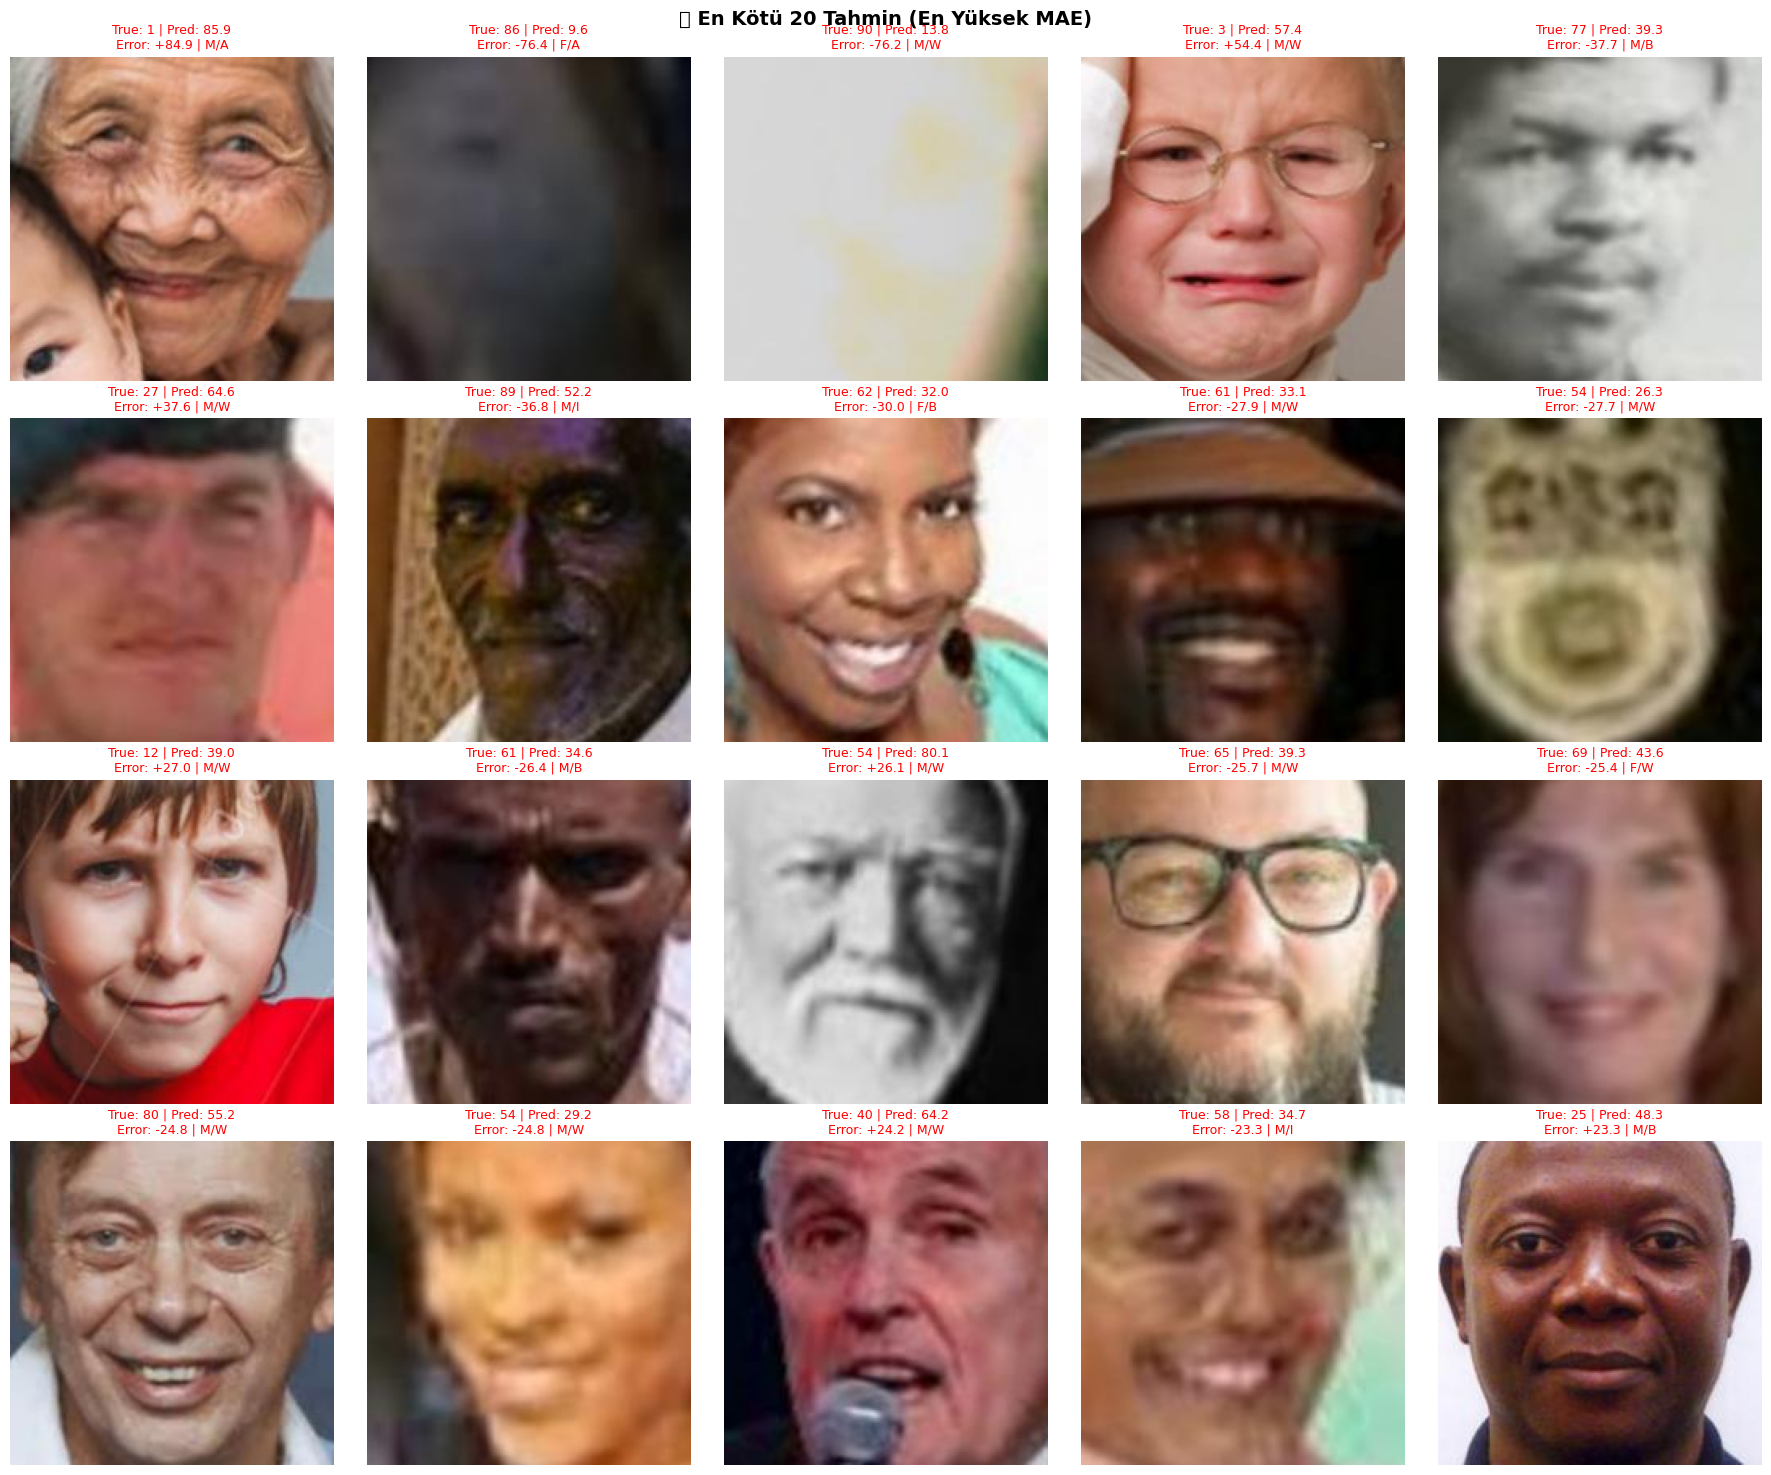


📸 Görsel kaydedildi: worst_predictions.png


In [64]:
# En kötü 20 örneği göster
import matplotlib.pyplot as plt
from PIL import Image

# En yüksek hataya sahip örnekleri bul
worst_examples = error_df.nlargest(20, 'abs_error')

print("🔴 EN KÖTÜ 20 TAHMİN (En yüksek hata)")
print("=" * 80)
for idx, row in worst_examples.iterrows():
    gender_str = "Erkek" if row['gender'] == 0 else "Kadın"
    race_names = ['White', 'Black', 'Asian', 'Indian', 'Other']
    race_str = race_names[int(row['race'])]
    error_sign = "+" if row['error'] > 0 else ""
    print(f"  {row['file'][:30]:30s} | Gerçek: {row['true_age']:2.0f} | Tahmin: {row['pred_age']:5.1f} | Hata: {error_sign}{row['error']:+5.1f} | {gender_str:5s} | {race_str}")

# Görsel olarak göster
fig, axes = plt.subplots(4, 5, figsize=(18, 15))
axes = axes.flatten()

for i, (idx, row) in enumerate(worst_examples.iterrows()):
    if i >= 20:
        break
    
    # Resmi yükle
    img_path = os.path.join(IMAGE_DIR, row['file'])
    try:
        img = Image.open(img_path).convert('RGB')
        axes[i].imshow(img)
    except:
        axes[i].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', fontsize=10)
    
    # Başlık: Gerçek vs Tahmin
    error_sign = "+" if row['error'] > 0 else ""
    gender_str = "M" if row['gender'] == 0 else "F"
    race_names = ['W', 'B', 'A', 'I', 'O']
    race_str = race_names[int(row['race'])]
    
    title = f"True: {row['true_age']:.0f} | Pred: {row['pred_age']:.1f}\nError: {error_sign}{row['error']:.1f} | {gender_str}/{race_str}"
    
    # Hata büyüklüğüne göre renk
    if abs(row['error']) > 20:
        title_color = 'red'
    elif abs(row['error']) > 15:
        title_color = 'orange'
    else:
        title_color = 'darkorange'
    
    axes[i].set_title(title, fontsize=9, color=title_color)
    axes[i].axis('off')

plt.suptitle('🔴 En Kötü 20 Tahmin (En Yüksek MAE)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('worst_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📸 Görsel kaydedildi: worst_predictions.png")

/tmp/ipykernel_50867/1394160379.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_mae = error_df.groupby('age_group')['abs_error'].agg(['mean', 'std', 'count'])


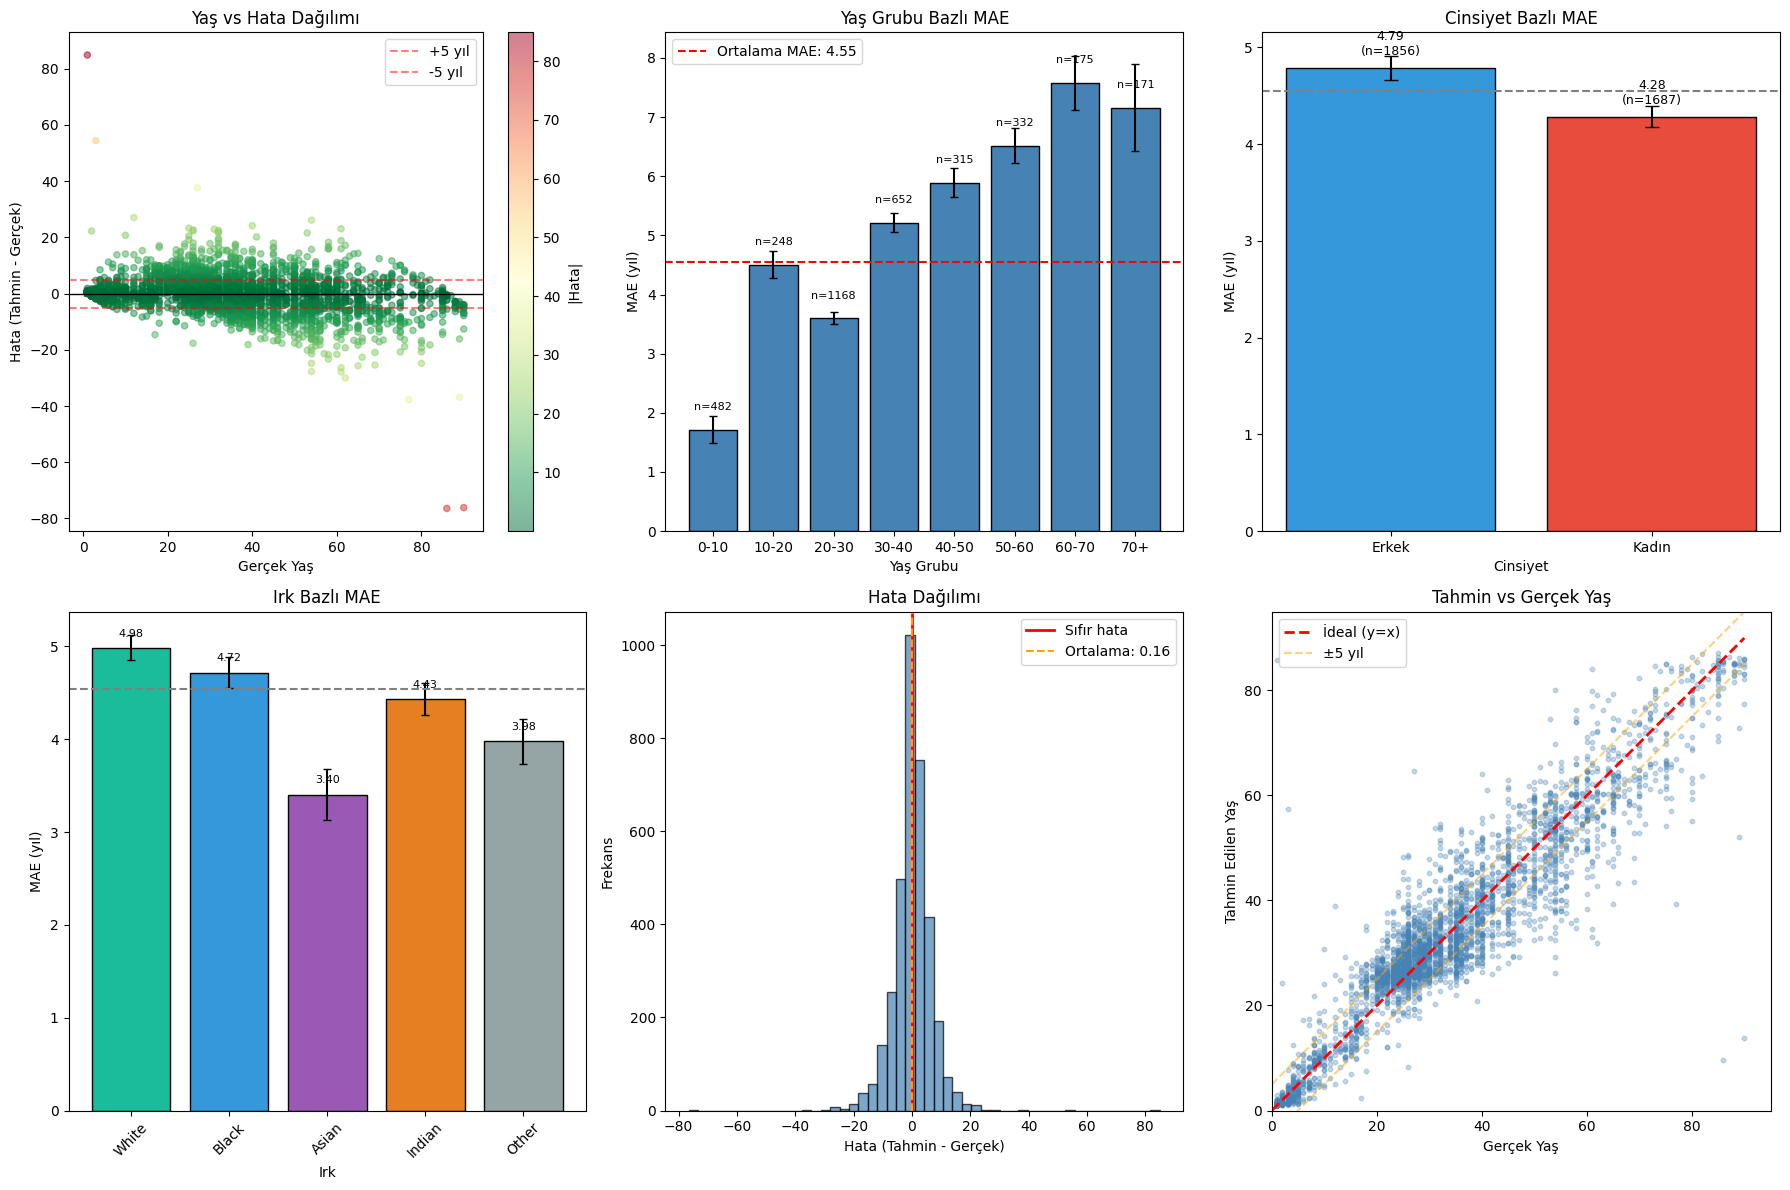


📊 Hata analizi kaydedildi: error_analysis.png


In [65]:
# Hata analizi: Yaş grubu, cinsiyet ve ırk bazlı
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Yaş vs Hata scatter plot
ax1 = axes[0, 0]
scatter = ax1.scatter(error_df['true_age'], error_df['error'], 
                      c=error_df['abs_error'], cmap='RdYlGn_r', alpha=0.5, s=20)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax1.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='+5 yıl')
ax1.axhline(y=-5, color='red', linestyle='--', alpha=0.5, label='-5 yıl')
ax1.set_xlabel('Gerçek Yaş')
ax1.set_ylabel('Hata (Tahmin - Gerçek)')
ax1.set_title('Yaş vs Hata Dağılımı')
plt.colorbar(scatter, ax=ax1, label='|Hata|')
ax1.legend()

# 2. Yaş grubu bazlı MAE
ax2 = axes[0, 1]
error_df['age_group'] = pd.cut(error_df['true_age'], 
                               bins=[0, 10, 20, 30, 40, 50, 60, 70, 100],
                               labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+'])
age_group_mae = error_df.groupby('age_group')['abs_error'].agg(['mean', 'std', 'count'])
bars = ax2.bar(age_group_mae.index.astype(str), age_group_mae['mean'], 
               yerr=age_group_mae['std']/np.sqrt(age_group_mae['count']), 
               capsize=3, color='steelblue', edgecolor='black')
ax2.axhline(y=error_df['abs_error'].mean(), color='red', linestyle='--', label=f'Ortalama MAE: {error_df["abs_error"].mean():.2f}')
ax2.set_xlabel('Yaş Grubu')
ax2.set_ylabel('MAE (yıl)')
ax2.set_title('Yaş Grubu Bazlı MAE')
ax2.legend()
# Her bar üzerine örnek sayısı yaz
for bar, (_, row) in zip(bars, age_group_mae.iterrows()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'n={int(row["count"])}', ha='center', va='bottom', fontsize=8)

# 3. Cinsiyet bazlı MAE
ax3 = axes[0, 2]
gender_mae = error_df.groupby('gender')['abs_error'].agg(['mean', 'std', 'count'])
gender_labels = ['Erkek', 'Kadın']
bars = ax3.bar(gender_labels, gender_mae['mean'], 
               yerr=gender_mae['std']/np.sqrt(gender_mae['count']),
               capsize=5, color=['#3498db', '#e74c3c'], edgecolor='black')
ax3.axhline(y=error_df['abs_error'].mean(), color='gray', linestyle='--')
ax3.set_xlabel('Cinsiyet')
ax3.set_ylabel('MAE (yıl)')
ax3.set_title('Cinsiyet Bazlı MAE')
for bar, (_, row) in zip(bars, gender_mae.iterrows()):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{row["mean"]:.2f}\n(n={int(row["count"])})', ha='center', va='bottom', fontsize=9)

# 4. Irk bazlı MAE
ax4 = axes[1, 0]
race_mae = error_df.groupby('race')['abs_error'].agg(['mean', 'std', 'count'])
race_names = ['White', 'Black', 'Asian', 'Indian', 'Other']
colors = ['#1abc9c', '#3498db', '#9b59b6', '#e67e22', '#95a5a6']
bars = ax4.bar(race_names, race_mae['mean'], 
               yerr=race_mae['std']/np.sqrt(race_mae['count']),
               capsize=3, color=colors, edgecolor='black')
ax4.axhline(y=error_df['abs_error'].mean(), color='gray', linestyle='--')
ax4.set_xlabel('Irk')
ax4.set_ylabel('MAE (yıl)')
ax4.set_title('Irk Bazlı MAE')
ax4.tick_params(axis='x', rotation=45)
for bar, (_, row) in zip(bars, race_mae.iterrows()):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{row["mean"]:.2f}', ha='center', va='bottom', fontsize=8)

# 5. Hata dağılımı histogramı
ax5 = axes[1, 1]
ax5.hist(error_df['error'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax5.axvline(x=0, color='red', linestyle='-', linewidth=2, label='Sıfır hata')
ax5.axvline(x=error_df['error'].mean(), color='orange', linestyle='--', 
            label=f'Ortalama: {error_df["error"].mean():.2f}')
ax5.set_xlabel('Hata (Tahmin - Gerçek)')
ax5.set_ylabel('Frekans')
ax5.set_title('Hata Dağılımı')
ax5.legend()

# 6. Tahmin vs Gerçek scatter
ax6 = axes[1, 2]
ax6.scatter(error_df['true_age'], error_df['pred_age'], alpha=0.3, s=10, c='steelblue')
ax6.plot([0, 90], [0, 90], 'r--', linewidth=2, label='İdeal (y=x)')
ax6.plot([0, 90], [5, 95], 'orange', linestyle='--', alpha=0.5, label='±5 yıl')
ax6.plot([0, 90], [-5, 85], 'orange', linestyle='--', alpha=0.5)
ax6.set_xlabel('Gerçek Yaş')
ax6.set_ylabel('Tahmin Edilen Yaş')
ax6.set_title('Tahmin vs Gerçek Yaş')
ax6.set_xlim(0, 95)
ax6.set_ylim(0, 95)
ax6.legend()
ax6.set_aspect('equal')

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Hata analizi kaydedildi: error_analysis.png")

In [66]:
# Detaylı hata özeti
print("=" * 80)
print("📊 DETAYLI HATA ANALİZİ")
print("=" * 80)

print("\n🎯 YAŞ GRUBU BAZLI PERFORMANS:")
print("-" * 60)
for age_group in ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']:
    group_data = error_df[error_df['age_group'] == age_group]
    if len(group_data) > 0:
        mae = group_data['abs_error'].mean()
        std = group_data['abs_error'].std()
        count = len(group_data)
        over_5 = (group_data['abs_error'] > 5).sum()
        over_10 = (group_data['abs_error'] > 10).sum()
        print(f"  {age_group:8s} | MAE: {mae:5.2f} ± {std:4.2f} | n={count:4d} | >5yıl: {over_5:3d} ({over_5/count*100:4.1f}%) | >10yıl: {over_10:3d} ({over_10/count*100:4.1f}%)")

print("\n👫 CİNSİYET BAZLI PERFORMANS:")
print("-" * 60)
for g, g_name in [(0, 'Erkek'), (1, 'Kadın')]:
    group_data = error_df[error_df['gender'] == g]
    if len(group_data) > 0:
        mae = group_data['abs_error'].mean()
        bias = group_data['error'].mean()  # Pozitif = yaşlı tahmin, negatif = genç tahmin
        print(f"  {g_name:8s} | MAE: {mae:5.2f} | Bias: {bias:+5.2f} | n={len(group_data)}")

print("\n🌍 IRK BAZLI PERFORMANS:")
print("-" * 60)
race_names = ['White', 'Black', 'Asian', 'Indian', 'Other']
for r, r_name in enumerate(race_names):
    group_data = error_df[error_df['race'] == r]
    if len(group_data) > 0:
        mae = group_data['abs_error'].mean()
        bias = group_data['error'].mean()
        print(f"  {r_name:8s} | MAE: {mae:5.2f} | Bias: {bias:+5.2f} | n={len(group_data)}")

print("\n⚠️ PROBLEMLİ ÖRNEKLER:")
print("-" * 60)
very_bad = error_df[error_df['abs_error'] > 15]
print(f"  >15 yıl hata: {len(very_bad)} örnek ({len(very_bad)/len(error_df)*100:.1f}%)")

bad = error_df[(error_df['abs_error'] > 10) & (error_df['abs_error'] <= 15)]
print(f"  10-15 yıl hata: {len(bad)} örnek ({len(bad)/len(error_df)*100:.1f}%)")

moderate = error_df[(error_df['abs_error'] > 5) & (error_df['abs_error'] <= 10)]
print(f"  5-10 yıl hata: {len(moderate)} örnek ({len(moderate)/len(error_df)*100:.1f}%)")

good = error_df[error_df['abs_error'] <= 5]
print(f"  ≤5 yıl hata: {len(good)} örnek ({len(good)/len(error_df)*100:.1f}%)")

print("\n🔍 EN PROBLEMLİ GRUPLAR:")
print("-" * 60)
# Yaş grubu x Cinsiyet x Irk bazlı en kötü performans
cross_analysis = error_df.groupby(['age_group', 'gender', 'race'])['abs_error'].agg(['mean', 'count'])
cross_analysis = cross_analysis[cross_analysis['count'] >= 5]  # En az 5 örnek
worst_groups = cross_analysis.nlargest(10, 'mean')
print("  (En az 5 örnek olan gruplar)")
for (age_g, gender, race), row in worst_groups.iterrows():
    g_str = "M" if gender == 0 else "F"
    r_str = ['W', 'B', 'A', 'I', 'O'][race]
    print(f"  {age_g:8s} / {g_str} / {r_str} | MAE: {row['mean']:5.2f} | n={int(row['count'])}")

📊 DETAYLI HATA ANALİZİ

🎯 YAŞ GRUBU BAZLI PERFORMANS:
------------------------------------------------------------
  0-10     | MAE:  1.72 ± 5.02 | n= 482 | >5yıl:  23 ( 4.8%) | >10yıl:   8 ( 1.7%)
  10-20    | MAE:  4.50 ± 3.59 | n= 248 | >5yıl:  93 (37.5%) | >10yıl:  13 ( 5.2%)
  20-30    | MAE:  3.60 ± 3.43 | n=1168 | >5yıl: 282 (24.1%) | >10yıl:  55 ( 4.7%)
  30-40    | MAE:  5.21 ± 4.06 | n= 652 | >5yıl: 279 (42.8%) | >10yıl:  82 (12.6%)
  40-50    | MAE:  5.89 ± 4.32 | n= 315 | >5yıl: 160 (50.8%) | >10yıl:  53 (16.8%)
  50-60    | MAE:  6.52 ± 5.50 | n= 332 | >5yıl: 157 (47.3%) | >10yıl:  71 (21.4%)
  60-70    | MAE:  7.57 ± 6.07 | n= 175 | >5yıl: 102 (58.3%) | >10yıl:  49 (28.0%)
  70+      | MAE:  7.16 ± 9.64 | n= 171 | >5yıl:  87 (50.9%) | >10yıl:  36 (21.1%)

👫 CİNSİYET BAZLI PERFORMANS:
------------------------------------------------------------
  Erkek    | MAE:  4.79 | Bias: +0.24 | n=1856
  Kadın    | MAE:  4.28 | Bias: +0.07 | n=1687

🌍 IRK BAZLI PERFORMANS:
-----------

/tmp/ipykernel_50867/1004795632.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cross_analysis = error_df.groupby(['age_group', 'gender', 'race'])['abs_error'].agg(['mean', 'count'])
